# Market domination predictions with N-BEATS

In [ ]:
%pip install -U torch torchvision
%pip install -qU darts scipy matplotlib requests scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.604    Total 

Epoch 199: 100%|██████████| 14/14 [00:02<00:00,  6.28it/s, train_loss=0.00128]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 14/14 [00:02<00:00,  6.28it/s, train_loss=0.00128]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


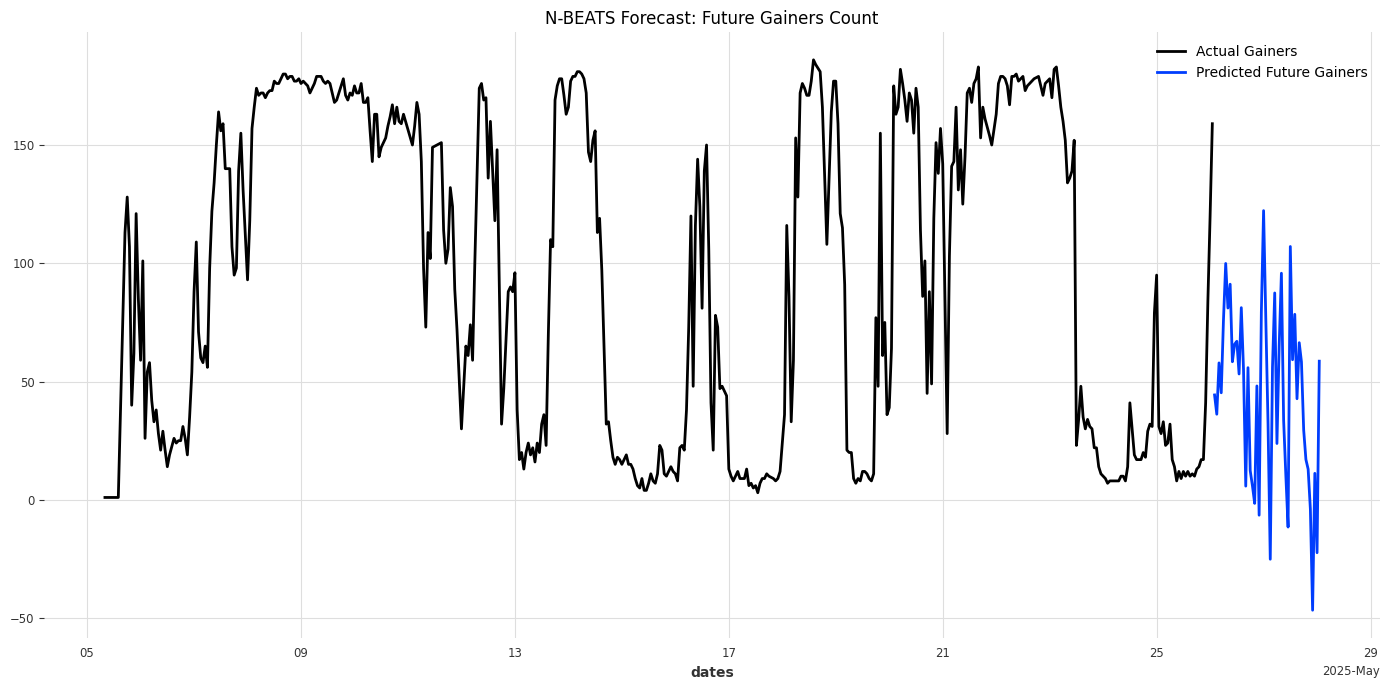

In [2]:
# Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Create TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['gainers_count'],
    fill_missing_dates=True,
    freq="h"
)

# Normalize and fill
scaler = Scaler()
filler = MissingValuesFiller()
series = filler.transform(series, method="linear")
series_scaled = scaler.fit_transform(series)

# input_chunk_length can't be increased because data needs to be 500+
input_chunk_length = 240
forecast_horizon = 48

# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=200,
    # smaller means more frequent weight updates
    batch_size=16,
    # keep constant for consistency across repeated runs
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
# Remove verbose for production
model.fit(series_scaled, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Plot
# To remove in production
plt.figure(figsize=(14, 7))
series.plot(label="Actual Gainers")
future_forecast_orig.plot(label="Predicted Future Gainers")
plt.title("N-BEATS Forecast: Future Gainers Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# With Box-Cox transformation

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.622    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MP

Epoch 99: 100%|██████████| 12/12 [00:02<00:00,  5.88it/s, train_loss=0.00507]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 12/12 [00:02<00:00,  5.88it/s, train_loss=0.00507]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


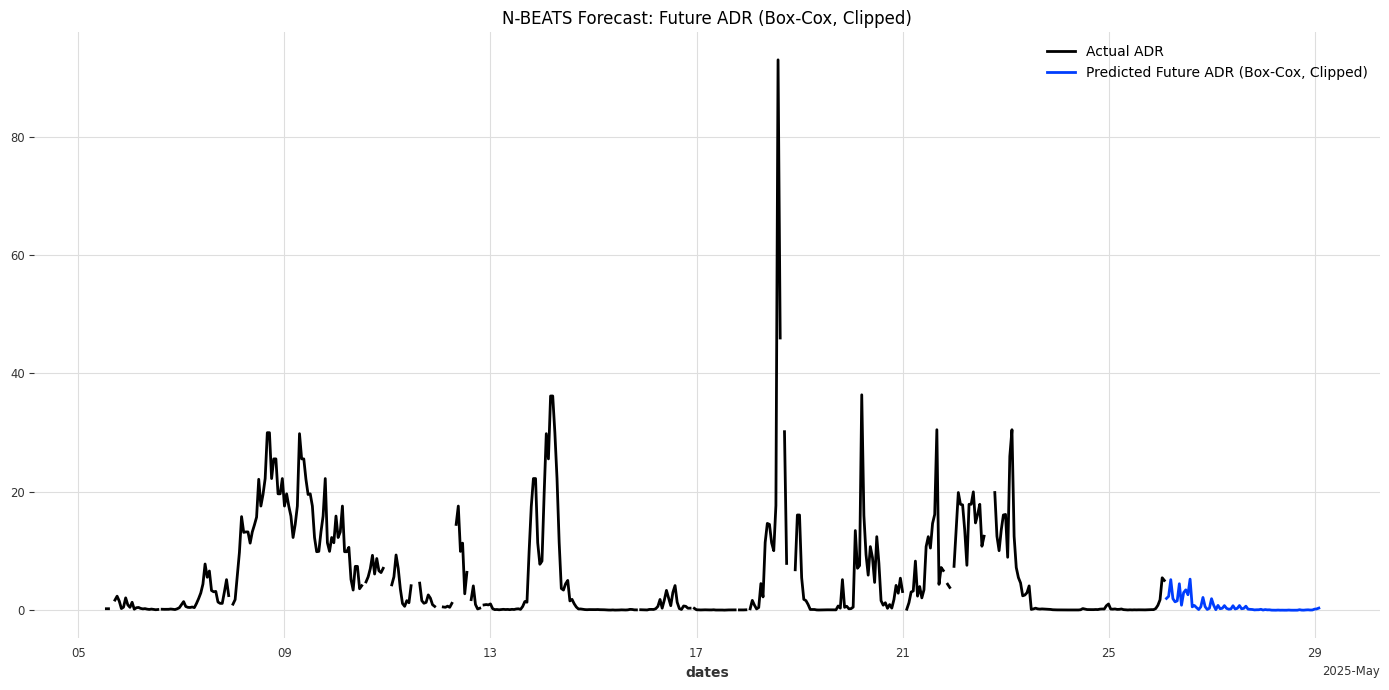

In [6]:
# ADR Forecasting using N-BEATS + Box-Cox

# Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim
import numpy as np
import torch

torch.set_default_dtype(torch.float32)  # Ensure float32 for MPS compatibility

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Calculate ADR
df['adr'] = df['gainers_count'] / df['losers_count']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['adr'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adr'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values *before* Box-Cox
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Apply Box-Cox transformation to the filled series
series_filled_values = series_filled.values().flatten()
if np.min(series_filled_values) <= 0:
    series_filled_values = series_filled_values + np.abs(np.min(series_filled_values)) + 1e-6

series_boxcox, lambda_param = boxcox(series_filled_values)
series_boxcox = TimeSeries.from_times_and_values(
    series_filled.time_index,
    series_boxcox.astype(np.float32),
    freq=series_filled.freq
)

# Normalize after Box-Cox and filling
scaler = Scaler()
series_scaled = scaler.fit_transform(series_boxcox)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=100,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
model.fit(series_scaled, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig_scaled = scaler.inverse_transform(future_forecast_scaled)

# Inverse Box-Cox transformation with float32 values
future_forecast_orig_scaled_vals = future_forecast_orig_scaled.values().flatten().astype(np.float32)
future_forecast_orig = TimeSeries.from_times_and_values(
    future_forecast_orig_scaled.time_index,
    inv_boxcox(future_forecast_orig_scaled_vals, lambda_param),
    freq=future_forecast_orig_scaled.freq
)

# Optional: Clip values
clipped_forecast_values = np.clip(future_forecast_orig.values().flatten(), 0, 10)
clipped_future_forecast = TimeSeries.from_times_and_values(
    future_forecast_orig.time_index,
    clipped_forecast_values,
    freq=future_forecast_orig.freq
)

# Plot
plt.figure(figsize=(14, 7))
series.plot(label="Actual ADR")
clipped_future_forecast.plot(label="Predicted Future ADR (Box-Cox, Clipped)")
plt.title("N-BEATS Forecast: Future ADR (Box-Cox, Clipped)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Final code using AD instead of ratio percentage diffs.
- New ADR uses percentage diffs (which is what we use for portfolio data) to make it smoother and less spiky in the extremme values.
- Removes Box-Cox because it does not work well with negative numbers.
- With this setup, clipping is also uncessary.
- Add learning rate scheduler, for gradual convergence (dynamic optimization)
- Add model evaluation (monitor how well it's learning)

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
import torch.optim as optim
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau


torch.set_default_dtype(torch.float32)  # Ensure float32 for MPS compatibility

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df['adp'] = (df['gainers_count'] - df['losers_count']) / (df['gainers_count'] + df['losers_count'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adp'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Z-score normalization
scaler = Scaler()
series_scaled = scaler.fit_transform(series_filled)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Train/validation split
train, val = series_scaled[:-forecast_horizon], series_scaled[-forecast_horizon:]

# Define N-BEATS model (no scheduler, fixed learning rate)
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=500,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-3},
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 10, "factor": 0.5, "monitor": 'train_loss'}
)

# Fit model
model.fit(train, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)
val_orig = scaler.inverse_transform(val)

# Evaluation
print("MAPE on validation set:", mape(val_orig, future_forecast_orig))

# Plot
plt.figure(figsize=(14, 7))

# Plot the actual series (including validation)
series_scaled.plot(label="Actual Normalized ADR", lw=2, color='black')

# Plot the predicted forecast after the validation set
future_forecast_scaled.plot(label="Predicted ADR (Normalized)", lw=2, color='blue')

plt.title("N-BEATS Forecast: Normalized ADR (Z-score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



ImportError: cannot import name 'MinMaxScaler' from 'darts.dataprocessing.transformers' (/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/darts/dataprocessing/transformers/__init__.py)

# N-BEATS forecast 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.622    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MP

Epoch 199: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s, train_loss=0.0051] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s, train_loss=0.0051]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.57it/s]
MAPE on validation set: 166.61554


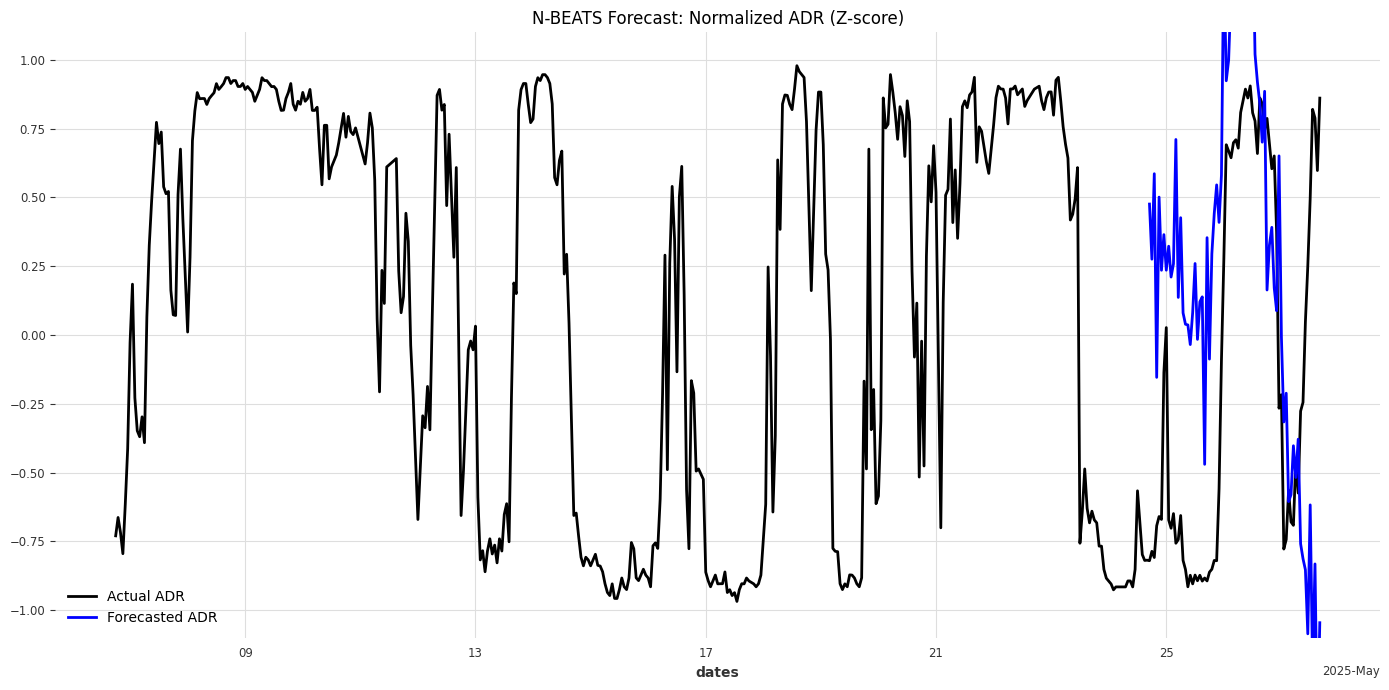

In [3]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
import torch.optim as optim
import numpy as np
import torch

torch.set_default_dtype(torch.float32)  # Ensure float32 for MPS compatibility

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df['adp'] = (df['gainers_count'] - df['losers_count']) / (df['gainers_count'] + df['losers_count'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adp'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Z-score normalization
scaler = Scaler()
series_scaled = scaler.fit_transform(series_filled)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Train/validation split
train, val = series_scaled[:-forecast_horizon], series_scaled[-forecast_horizon:]
train_orig, val_orig = series_filled[:-forecast_horizon], series_filled[-forecast_horizon:]


# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=200,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
model.fit(train, verbose=True)

# Forecast future beyond last observed point
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Validation actuals (only for MAPE calculation)
val_orig = scaler.inverse_transform(val)

# Evaluation
print("MAPE on validation set:", mape(val_orig, future_forecast_orig))

# Plot
plt.figure(figsize=(14, 7))

# Plot the combined actual data (training and validation)
series_filled.plot(label="Actual ADR", lw=2, color='black')

# Plot the forecast starting from the end of the training data
future_forecast_orig.plot(label="Forecasted ADR", lw=2, color='blue')

plt.title("N-BEATS Forecast: Normalized ADR (Z-score)")
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# Production Deployment: Export Model & Predict

This cell exports the trained N-BEATS model and provides a minimal FastAPI app for serving predictions. It also includes deployment instructions for a Digital Ocean droplet.

/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training production model on the entire dataset...



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.622    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 799: 100%|██████████| 11/11 [00:01<00:00,  5.83it/s, train_loss=0.00626]

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 799: 100%|██████████| 11/11 [00:01<00:00,  5.82it/s, train_loss=0.00626]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Generating forecast for the next 72 periods...
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


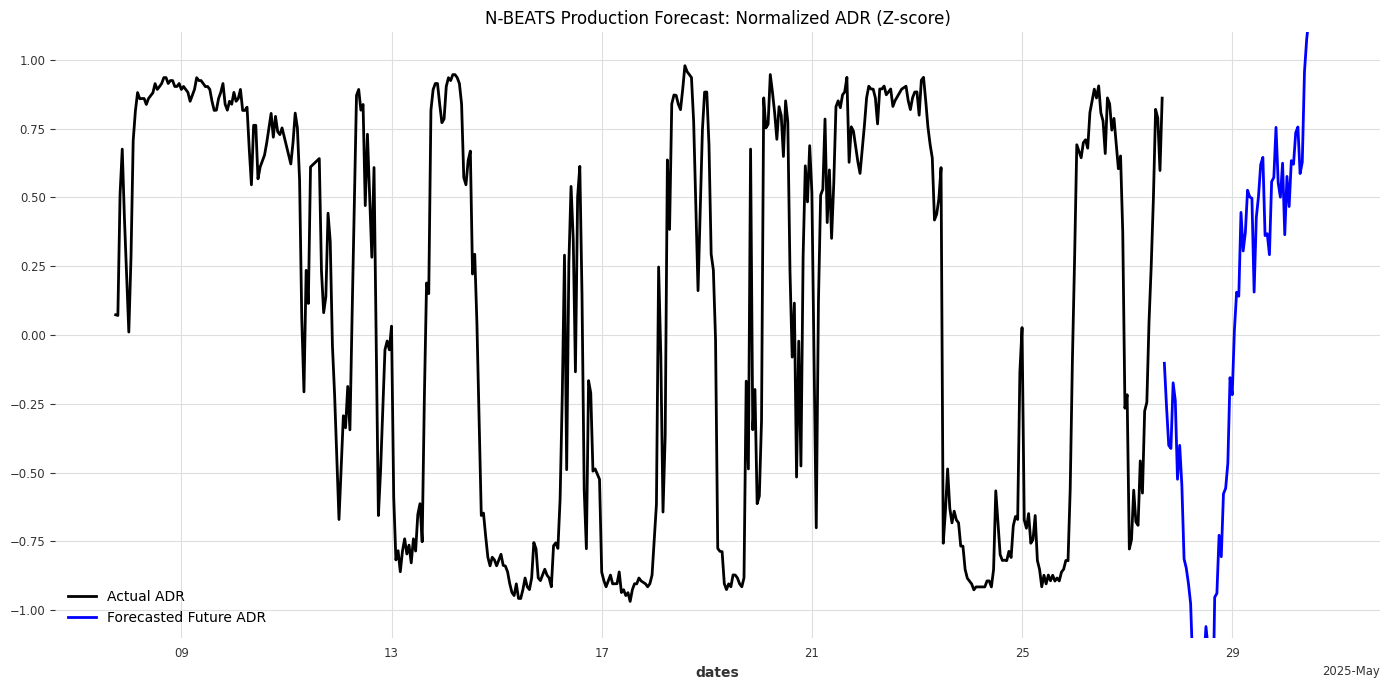

In [1]:

import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.set_default_dtype(torch.float32)

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df['adp'] = (df['gainers_count'] - df['losers_count']) / (df['gainers_count'] + df['losers_count'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adp'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Z-score normalization
scaler = Scaler()
series_scaled = scaler.fit_transform(series_filled)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Define N-BEATS model with optimized hyperparameters (assuming you found them during development)
# Use the best hyperparameters determined from your experimentation with the validation set
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=600,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}, # Use the optimized learning rate
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 10, "factor": 0.5, "monitor": 'train_loss'}
)

# Fit model on the entire scaled series for production
print("Training production model on the entire dataset...")
model.fit(series_scaled, verbose=True)

# Forecast into the future from the end of the entire series
print(f"Generating forecast for the next {forecast_horizon} periods...")
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Plot the entire actual series and the future forecast
plt.figure(figsize=(14, 7))

# Plot the entire actual series
series_filled.plot(label="Actual ADR", lw=2, color='black')

# Plot the future forecast extending from the end of the actual data
future_forecast_orig.plot(label="Forecasted Future ADR", lw=2, color='blue')

plt.title("N-BEATS Production Forecast: Normalized ADR (Z-score)")
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# You can now use future_forecast_orig for your predictions

# Optional: Save the production model
# model.save_model('nbeats_adr_production_model.pth')

# With covariate total_volume

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.8 M  | train
-------------------------------------------------------------
9.8 M     Trainable params
4.2 K     Non-trainable params
9.8 M     Total params
39.219    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MP

Epoch 199: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s, train_loss=0.014]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s, train_loss=0.014]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
future_forecast_orig <TimeSeries (DataArray) (dates: 72, component: 1, sample: 1)> Size: 288B
array([[[6.3031444e+09]],

       [[6.3768238e+09]],

       [[6.4189665e+09]],

       [[7.1124234e+09]],

       [[6.5903944e+09]],

       [[6.1819617e+09]],

       [[6.3996539e+09]],

       [[5.5380004e+09]],

       [[5.8741320e+09]],

       [[6.6583245e+09]],

...

       [[2.8754286e+09]],

       [[2.6168742e+09]],

       [[2.3400517e+09]],

       [[2.3343306e+09]],

       [[1.2543524e+09]],

       [[1.5452211e+09]],

       [[1.2240943e+09]],

       [[7.8772538e+08]],

       [[6.7495904e+08]],

       [[1.6612223e+09]]], dtype=float32)
Coordinates:
  * dates      (dates) datetime64[ns] 576B 2025-05-25 ... 2025-05-27T23:00:00
  * component  (component) object 8B 'adp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None
MAP

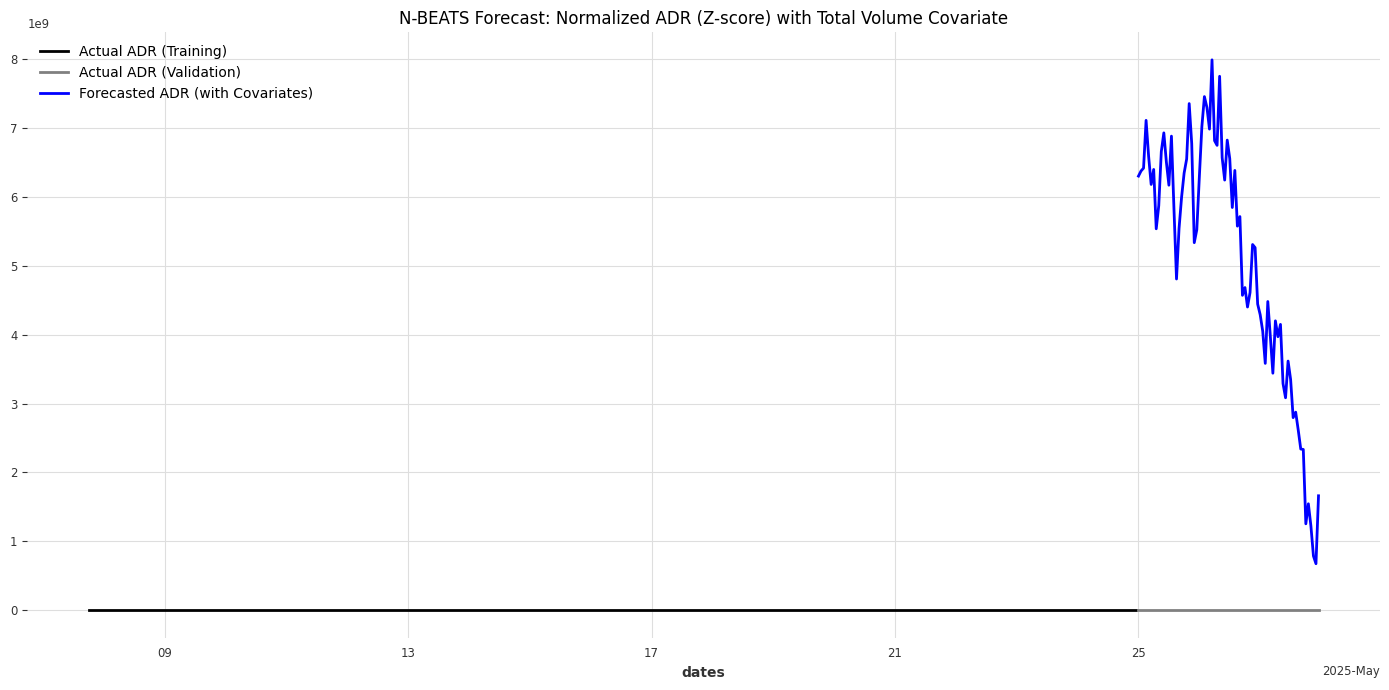

In [6]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
import torch.optim as optim
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.set_default_dtype(torch.float32)

# Fetch data (same as before)
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = requests.get(url).json() # Use requests.get(url).json() directly

df = pd.DataFrame(data['data'])

# Clean and preprocess (same as before)
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering (same as before, including total_volume)
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff (same as before)
df['adp'] = (df['gainers_count'] - df['losers_count']) / (df['gainers_count'] + df['losers_count'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adp'],
    fill_missing_dates=True,
    freq="h"
)

# Create covariate series for total_volume
covariate_series = TimeSeries.from_dataframe(
    df,
    value_cols=['total_volume'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values for both series and covariate series
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")
covariate_series_filled = filler.transform(covariate_series, method="linear")


# Z-score normalization for both series and covariate series
scaler = Scaler()
series_scaled = scaler.fit_transform(series_filled)
covariate_series_scaled = scaler.fit_transform(covariate_series_filled)

# Parameters (same as before)
input_chunk_length = 240
forecast_horizon = 72

# Train/validation split for both series and covariate series
train_scaled, val_scaled = series_scaled[:-forecast_horizon], series_scaled[-forecast_horizon:]
train_orig, val_orig = series_filled[:-forecast_horizon], series_filled[-forecast_horizon:]
train_covariate_scaled, val_covariate_scaled = covariate_series_scaled[:-forecast_horizon], covariate_series_scaled[-forecast_horizon:]

# Define N-BEATS model with future covariates
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=200,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4},
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 12, "factor": 0.2, "monitor": 'train_loss'}
)

# Fit model with future covariates
model.fit(
    train_scaled,
    past_covariates=train_covariate_scaled,
    verbose=True
)

# Forecast using future covariates for both validation and forecast periods
future_forecast_scaled = model.predict(n=forecast_horizon, past_covariates=covariate_series_scaled[-(input_chunk_length + forecast_horizon):])
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

print("future_forecast_orig", future_forecast_orig)

# Evaluation (using the original scale validation data)
print("MAPE on validation set:", mape(val_orig, future_forecast_orig))

# Plot
plt.figure(figsize=(14, 7))

# Plot actual normalized ADR for training and validation periods
train_orig.plot(label="Actual ADR (Training)", lw=2, color='black')
val_orig.plot(label="Actual ADR (Validation)", lw=2, color='gray')

# Plot forecast extending from the end of the training data
future_forecast_orig.plot(label="Forecasted ADR (with Covariates)", lw=2, color='blue')

plt.title("N-BEATS Forecast: Normalized ADR (Z-score) with Total Volume Covariate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()